In [10]:
import tyssue

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
# import seaborn as sns
%matplotlib inline

import tyssue as ty

from tyssue.core.sheet import Sheet
from tyssue.geometry.planar_geometry import PlanarGeometry
from tyssue.draw.mpl_draw import sheet_view
from tyssue.config import load_default

In [4]:
datasets = {}

bi_verts = [[0., 0.], [0., 0.]]
bi_edges = [[]]

tri_verts = [[0, 0],
             [1, 0],
             [-0.5, 3**0.5/2],
             [-0.5, -3**0.5/2]]

tri_edges = [[0, 1, 0],
             [1, 2, 0],
             [2, 0, 0],
             [0, 3, 1],
             [3, 1, 1],
             [1, 0, 1],
             [0, 2, 2],
             [2, 3, 2],
             [3, 0, 2]]

datasets['edge'] = pd.DataFrame(data=np.array(tri_edges),
                                columns=['srce', 'trgt', 'face'])
datasets['face'] = pd.DataFrame(data=np.zeros((3, 2)), columns=['x', 'y'])

datasets['vert'] = pd.DataFrame(data=np.array(tri_verts),
                                columns=['x', 'y'])



In [80]:
reo_specs = {
    "edge": {
        "arc_length": 0.0, ## L
        "lenght": 0.0, ## a that's the chord length
        "arc_chord_angle": 0.0, ## alpha
        "sagitta": 0.0, ## h
        "chord_orient": 0.0, ## beta
        "curvature": 0.0,
        "sigma": 0.0,
        "dx": 0.0,
        "dy": 0.0,
        "nz": 0.0,
        "sub_area": 0.0,
        "opposite": -1,
        "modulus": 0.0,
        "viscosity": 0.0,
        "motor": 0.0
        },
    "face": {
        "x": 0.0,
        "y": 0.0,
        "pressure": 0.0,
        "area": 0.0,
        },
    "vert": {
        "x": 0.0,
        "y": 0.0
        }
    }


In [81]:

sheet = Sheet('tri_junction', datasets, reo_specs, coords=['x', 'y'])
PlanarGeometry.update_dcoords(sheet)
PlanarGeometry.update_length(sheet)
PlanarGeometry.update_normals(sheet)

PlanarGeometry.update_areas(sheet)


In [58]:
sheet.edge_df.head()

,srce,trgt,face,sigma,opposite,dy,chord_orient,height,arc_length,dx,arc_chord_angle,motor,lenght,modulus,viscosity,length,sub_area,nz
0,0,1,0,0,5,0.000000,0,0,0,1.0,0,0,0,0,0,1.000000,0.000000,0.000000
1,1,2,0,0,-1,0.866025,0,0,0,-1.5,0,0,0,0,0,1.732051,0.433013,0.866025
2,2,0,0,0,6,-0.866025,0,0,0,0.5,0,0,0,0,0,1.000000,0.000000,0.000000
3,0,3,1,0,8,-0.866025,0,0,0,-0.5,0,0,0,0,0,1.000000,0.000000,0.000000
4,3,1,1,0,-1,0.866025,0,0,0,1.5,0,0,0,0,0,1.732051,0.433013,0.866025


## Equations

* By half edges


* By full edges
  
  - Laplace 
      $$\Delta P_{ab} = (\sigma_{ij} + \sigma_{ji}) C$$
  - corde x $\Delta x_{ij} =  2 a_{ij} \cos{\beta_{ji}}$
  - corde y $\Delta y_{ij} =  2 a_{ij} \sin{\beta_{ji}}$
  - curvature $L_{ij}C_{ij} = 2*\alpha_{ij}$
  - sagitta $h \cos{\alpha/2} = a \sin {\alpha/2}$
  - rheo $\dot{L} = L\left(\dot{\sigma_{ij}} / k_{ij} + \sigma_{ij} / \eta_{ij} - m_{ij}\right) + vc(he_{ij} + vc(he_{ji}$
   - strain rate $\dot{\sigma_{ij}} / k_{ij} + \sigma_{ij} / \eta_{ij} - m_{ij} = \dot{\sigma_{ji}} / k_{ji} + \sigma_{ji} / \eta_{ji} - m_{ji}$ 
   
* By vertices
  
  - plateau x: $\sum_i \sum_j (\sigma_{ij} \cos(\beta_{ij} - \alpha_{ij}) - \sum_j \sum_i \sigma_{ji} \cos(\beta_{ji} + \alpha_{ji}) = 0$ 
  - plateau y: $\sum_i \sum_j (\sigma_{ij} \sin(\beta_{ij} - \alpha_{ij}) - \sum_j \sum_i \sigma_{ji} \sin(\beta_{ji} + \alpha_{ji}) = 0$
  
* By face
  - Volume : sum_face (sub_area + f(\alpha) for curvature (see Maxime's report) 

f_v(\beta)


In [48]:
def arc_area(alpha):
    alpha = np.asarray(alpha)
    u = np.tan(alpha / 2)
    f_v = (alpha * (1 + u**2)**2 -
           4*u + 2*u*(1 + u**2)) / (4 * u**3)
    f_v[u == 0.0] = 0
    return f_v

def arc_area_alt(alpha):
    alpha = np.asarray(alpha)
    f_v = (1 / np.sinc(alpha/np.pi) - 
           np.cos(alpha)) / np.sin(alpha)
    f_v[np.sin(alpha) == 0.0] = 0
    return f_v

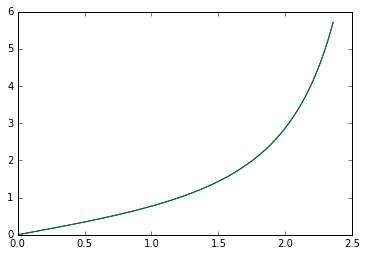

In [49]:


alpha = np.linspace(0, 3*np.pi/4, 500)

fig, ax = plt.subplots()

ax.plot(alpha, np.tan(alpha/2)*arc_area(alpha))
ax.plot(alpha, arc_area_alt(alpha))


In [50]:
arc_area([0, np.pi])

array([  0.00000000e+00,   1.28265254e+16])

In [51]:
%timeit arc_area(alpha)
%timeit arc_area_alt(alpha)

10000 loops, best of 3: 77.4 µs per loop
10000 loops, best of 3: 50.9 µs per loop


In [14]:
%pdb

Automatic pdb calling has been turned ON


In [59]:

def get_opposites(sheet):
    
    for i, edge in sheet.edge_df.iterrows():
        srce, trgt = edge[['srce', 'trgt']]
        opp = sheet.edge_df[(sheet.edge_df['srce'] == trgt) &
                            (sheet.edge_df['trgt'] == srce)].index.values
        if opp.size > 0:
            sheet.edge_df.loc[i, 'opposite'] = opp[0]
            
get_opposites(sheet)

In [67]:
opp = sheet.edge_df.opposite

In [71]:
free_edges = opp[opp == -1].index
dble_edges = opp[opp != -1]


In [74]:
dble_edges

0    5
2    6
3    8
5    0
6    2
8    3
Name: opposite, dtype: int64

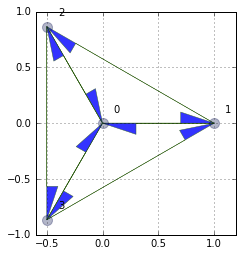

In [75]:
fig, ax = sheet_view(sheet, ['x', 'y'])
srce_pos = sheet.upcast_srce(sheet.vert_df[sheet.coords])

for idx, v in sheet.vert_df.iterrows():
    ax.text(v.x+0.1, v.y+0.1, str(idx))
    

In [88]:
sheet.edge_df[['srce', 'trgt', 'opposite']]

,srce,trgt,opposite
0,0,1,5
1,1,2,-1
2,2,0,6
3,0,3,8
4,3,1,-1
5,1,0,0
6,0,2,2
7,2,3,-1
8,3,0,3


In [131]:
sheet.edge_df['arc_chord_angle'] = np.array([0.3, 0.8, 0.3,
                                             0.3, 0.8, -0.3,
                                             -0.3, 0.8, -0.3]) * np.pi / 2
sheet.edge_df['curvature'] = 1 * np.sign(sheet.edge_df['arc_chord_angle'])

sheet.edge_df['arc_length'] = 2 * (sheet.edge_df['arc_chord_angle'] /
                                   sheet.edge_df['curvature'])

sheet.edge_df['chord_orient'] = np.pi - np.arctan2(sheet.edge_df['dy'], 
                                                   sheet.edge_df['dx'])

sheet.edge_df['sagitta'] = sheet.edge_df['length'] * np.tan(sheet.edge_df['arc_chord_angle']/2)


In [132]:
def get_arc_centers(sheet):
    
    srce_pos = sheet.upcast_srce(sheet.vert_df[sheet.coords])
    trgt_pos = sheet.upcast_trgt(sheet.vert_df[sheet.coords])
    
    radius = 1 / sheet.edge_df['curvature']
    
    center_x = ((srce_pos.x + trgt_pos.x)/2 +
                 (radius - sheet.edge_df['sagitta']) * 
                 sheet.edge_df['dy'] / sheet.edge_df['length'])

    center_y = ((srce_pos.y + trgt_pos.y)/2 -
                 (radius - sheet.edge_df['sagitta']) * 
                 sheet.edge_df['dx'] / sheet.edge_df['length'])
    
    alpha = sheet.edge_df['arc_chord_angle']
    beta = sheet.edge_df['chord_orient']
    
    theta1 = -alpha + beta - np.pi/2
    theta2 = alpha + beta - np.pi/2
    
    center_data = pd.DataFrame.from_dict({
            'R': radius,
            'x': center_x,
            'y': center_y,
            'theta1': theta1,
            'theta2': theta2
            })
    return center_data

In [133]:
center_data = get_arc_centers(sheet)

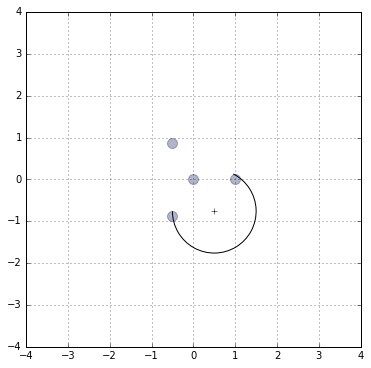

In [136]:
from matplotlib.collections import PatchCollection

from matplotlib.patches import Arc

fig, ax = sheet_view(sheet, **{'edge': {'visible':False}})

curves = []
for idx, edge in center_data.iterrows():
    
    patch = Arc(edge[['x', 'y']],
                2*np.abs(edge['R']),
                2*np.abs(edge['R']),
                edge['theta1']*180/np.pi,
                edge['theta2']*180/np.pi)
    curves.append(patch)
    break
ax.plot(center_data.x.loc[0], center_data.y.loc[0], 'k+')
ax.add_collection(PatchCollection(curves, False, **{'facecolors':'none'}))

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
fig.set_size_inches(6, 6)

In [35]:
import matplotlib
matplotlib.patches.CirclePolygon?

In [11]:
sheet.edge_df

,nz,ny,nx,dx,length,srce,dy,trgt,dz,face,sub_area
edge,,,,,,,,,,,
0,-0,0,0,1.0,1.000000,0,0.000,1,0,0,0
1,-0,0,0,0.5,0.999978,1,0.866,2,0,0,0
2,0,0,0,-0.5,0.999978,2,0.866,3,0,0,0
3,0,0,0,-1.0,1.000000,3,0.000,4,0,0,0
4,0,0,0,-0.5,0.999978,4,-0.866,5,0,0,0
5,0,0,0,0.5,0.999978,5,-0.866,0,0,0,0
6,0,0,0,-0.5,0.999978,0,0.866,5,0,1,0
7,0,0,0,-1.0,1.000000,5,0.000,6,0,1,0
8,0,0,0,-0.5,0.999978,6,-0.866,7,0,1,0
